# Reinforcement Learning - HW 2

## by Clarice Mottet

0. **[Part 0: Set Up](#part0)**
- **Objective**: Initialize programming environment.
- **Tasks:**
    - Set up libraries
    - Initialize global variables
    - Create functions to be used throughout notebook base on problem set up

1. **[Part 1: Approximate Policy Evaluation](#part1)**
- **Objective**: Study the performance of simple policies using TD(0) and LSTD
- **Tasks:**
  - TD(0) algorithm creation
  - LSTD algorithm creation
  - Lazy policy (TD(0) and LSTD implementation)
  - Aggressive policy (TD(0) and LSTD implementation)
  - Evaluate efficacy under three feature maps with $10^4, 10^5, 10^6, 10^7$
  - Plot the resulting value functions and compare to value function results from HW1

2. **[Part 2: Approximate Policy Iteration](#part2)**
- **Objective**: implement an approximate policy iteration method
- **Tasks:**
  - Create approximate policy iteration method
  - Plot value function after 10 and 100 iterations and compare to value function from Part1
  - Compare the value function to the optimal value function from HW1
  - Plot the service rates assigned by the final policy, interpret

## <a id='part0'>Part 0: Set Up</a>
- **Objective**: Initialize programming environment.
- **Tasks:**
    - Set up libraries
    - Initialize global variables
    - Create functions to be used throughout notebook base on problem set up

- Set up libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time


- Initialize global variables

In [70]:
N_MAX = 100
GAMMA = 0.9

Q_LOW = 0.51
Q_HIGH = 0.6

COST_LOW = 0.0
COST_HIGH = 0.01

ARRIVAL_RATE = 0.5

ACTION_LIST = [0, 1] #action_ind (low = 0, high = 1)

list_iters = [10, 20, 50, 100]

#step size parameters for alpha_t = (A/t+B) in TD(0)
A = 10e5
B = 10e5

- Create functions to be used throughout notebook base on problem set up
    - reward functions
    - transition functions
    - evaluation functions
    - simulation functions
    - feature maps
    - policy functions from hw1
    - value iteration and policy iteration from hw1

In [4]:
#reward functions

def action_cost(action_ind):
    if action_ind == 0:
        return COST_LOW
    else:
        return COST_HIGH

def reward_calc(x, action_ind):
    return -((x/N_MAX)**2) - action_cost(action_ind)

def reward_under_policy(pi):
    r_pi = np.zeros(N_MAX)
    for x in range(0, N_MAX):
        # action_ind = None
        for a in ACTION_LIST:
            r_pi[x] += reward_calc(x, a)*pi[x,a]
    return r_pi


In [5]:
#transitions functions

def reduction_rate(action_ind):
    if action_ind == 0:
        return Q_LOW
    else:
        return Q_HIGH
    
def transition_framework():
    #conditional matrix P(x, x_prime, a)
    P = np.zeros((N_MAX,N_MAX,2))
    for x in range(0,N_MAX):
        for a in ACTION_LIST:
            if x == 0:
                P[x, 0, a] = (1-ARRIVAL_RATE) + (reduction_rate(a))*(ARRIVAL_RATE)
                P[x, 1, a] = (reduction_rate(a))*(1-ARRIVAL_RATE)
            elif x == (N_MAX-1):
                P[x, N_MAX-2, a] = (reduction_rate(a))*(1-ARRIVAL_RATE)
                P[x, N_MAX-1, a] = (1-reduction_rate(a)) + (reduction_rate(a))*(ARRIVAL_RATE)
            else:
                #(decrement, increment)
                for x_prime in [x-1, x, x+1]:
                    if x_prime == (x-1):
                        #(1,0)
                        P[x, x_prime, a] = (reduction_rate(a))*(1-ARRIVAL_RATE)
                    if x_prime == x:
                        #(0,0) + (1,1)
                        P[x, x_prime, a] = (1-reduction_rate(a))*(1-ARRIVAL_RATE) + (reduction_rate(a))*(ARRIVAL_RATE)
                    if x_prime == (x+1):
                        #(0,1)
                        P[x, x_prime, a] = (1-reduction_rate(a))*(ARRIVAL_RATE)
    return P

def transition_under_policy(pi):
    P = transition_framework()

    #create transition matrix based on policy P(x, x_prime)
    P_pi = np.zeros((N_MAX,N_MAX))
    for x in range(N_MAX):
        for x_prime in [x-1, x, x+1]:
            if (x_prime < N_MAX) and (x_prime >= 0):
                for a in ACTION_LIST:
                    P_pi[x,x_prime] += P[x,x_prime,a]*pi[x,a]
    return P_pi


In [6]:
#evaluation functions

def value_under_policy(pi):
    P = transition_framework()
    r = reward_under_policy(pi)

    X = np.size(P,1)
    V_pi = np.zeros((X))

    P_pi = transition_under_policy(pi)
    V_pi = np.linalg.inv(np.eye(X) - GAMMA*P_pi).dot(r)
    return V_pi


In [7]:
#simulation functions

def next_state(state_val, action_ind):
    increment_t = random.choices([0, 1], weights=[1-ARRIVAL_RATE, ARRIVAL_RATE])[0]
    decrement_t = random.choices([0, 1], weights=[1-reduction_rate(action_ind), reduction_rate(action_ind)])[0]
    net_t = increment_t - decrement_t
    return min(N_MAX-1, max(state_val + net_t, 0))

def plot_results(data, x_title, y_title, title, color):
    plt.figure(figsize=(5, 3))
    plt.plot(data, linestyle = 'dotted', color = color)
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.title(title)
    plt.show()


In [56]:
#feature maps

def fine_feature_map(x):
    phi = np.zeros(N_MAX)
    phi[x] = 1
    return phi

def coarse_feature_map(x):
    phi = np.zeros(int(N_MAX/5))
    for i in range(int(N_MAX/5)):
        if x in range(int(5*i),int(5*i)+5):
            phi[i] = 1
    return phi

def piecewise_feature_map(x):
    phi = np.zeros((int((N_MAX/5))))

    phi_coarse = coarse_feature_map(x)
    for i in range(int(N_MAX/5)):
        phi[i] = phi_coarse[i]
        if phi[i] == 1:
            phi[i+int(N_MAX/5)] = phi[i]*((x - 5*i)/5)
    return phi


In [8]:
#policies

def policy_lazy():
    pi = np.zeros((N_MAX,2))
    for x in range(0,N_MAX):
        pi[x, 0] = 1 #action_ind (low = 0, high = 1)
        pi[x, 1] = 0
    return pi

def policy_aggr():
    pi = np.zeros((N_MAX,2))
    for x in range(0,N_MAX):
        if x < 50:
            pi[x, 0] = 1 #action_ind (low = 0, high = 1)
            pi[x, 1] = 0
        else:
            pi[x, 0] = 0 
            pi[x, 1] = 1 #action_ind (low = 0, high = 1)
    return pi


In [10]:
#HW1 functions

def value_iteration(max_iter):
    #initialize frameworks 
    P = transition_framework()
    r = np.zeros((N_MAX, 2))
    for x in range(N_MAX):
        for a in ACTION_LIST:
            r[x,a] = reward_calc(x,a)

    #initialize value function
    V = np.zeros((N_MAX, 1))

    #value iteration
    for k in range(max_iter):
        V_star = -np.inf
        for a in range(2):
            V_star = np.maximum(V_star, r[:, a].reshape([-1, 1]) + GAMMA* P[:, :, a].dot(V))
        V = V_star
    
    return V.flatten()

def policy_iteration(max_iter):

    #initialize frameworks
    P = transition_framework()
    pi_star = policy_aggr()

    #policy iteration
    for k in range(max_iter):

        V_new = value_under_policy(pi_star)

        V_max = np.zeros((N_MAX,2))
        for x in range(N_MAX):
            for a in ACTION_LIST:
                V_max[x,a] = reward_calc(x,a) + GAMMA*P[x, :, a].dot(V_new)

        pi_star = np.eye(V_max.shape[1])[np.argmax(V_max, axis=1)]

    return value_under_policy(pi_star), pi_star

# pi_lazy = policy_lazy()
# V_pi_lazy = value_under_policy(pi_lazy)
# pi_aggr = policy_aggr()
# V_pi_aggr = value_under_policy(pi_aggr)

# fig, axes = plt.subplots(1, 4, figsize=(30, 6))

# for i, ax in enumerate(axes):
#     V_star_value = value_iteration(list_iters[i])
#     V_star_policy, pi_star_policy = policy_iteration(list_iters[i])
#     V_star_diff = V_star_value - V_star_policy

#     # ax.plot(V_star_value, linestyle = 'dotted', color = 'green', label = 'Value')
#     # ax.plot(V_star_policy, linestyle = 'dotted', color = 'blue', label = 'Policy')
#     ax.plot(V_star_diff, linestyle = 'dotted', color = 'purple', label = 'Difference')
#     ax.title.set_text(f'Compare Value and Policy Iteration:{list_iters[i]}')
#     ax.legend()

# plt.show()

# fig, axes = plt.subplots(1, 4, figsize=(30, 6))

# for i, ax in enumerate(axes):
#     V_star_value = value_iteration(list_iters[i])
#     V_star_diff_lazy = V_star_value - V_pi_lazy
#     V_star_diff_aggr = V_star_value - V_pi_aggr

#     ax.plot(V_star_diff_lazy, linestyle = 'dotted', color = 'red', label = 'Diff-Lazy')
#     ax.plot(V_star_diff_aggr, linestyle = 'dotted', color = 'orange', label = 'Diff-Aggr')
#     ax.title.set_text(f'Compare Value Iteration to Part1: {list_iters[i]}')
#     ax.legend()

# plt.show()

## <a id='part1'>Part 1: Approximate Policy Evaluation</a>
- **Objective**: Study the performance of simple policies using TD(0) and LSTD
- **Tasks:**
  - TD(0) algorithm creation
  - LSTD algorithm creation
  - Lazy policy (TD(0) and LSTD implementation)
  - Aggressive policy (TD(0) and LSTD implementation)
  - Evaluate efficacy under three feature maps with $10^4, 10^5, 10^6, 10^7$
  - Plot the resulting value functions and compare to value function results from HW1

- TD(0) algorithm creation

In [85]:
#TD(O) algorithm

def td_zero(V_init, x_init, pi, max_iter):

    #initialize
    V_t = V_init
    V_tpo = V_init

    x_t = x_init
    a_t = np.argmax(pi[x_t])
    x_tpo = next_state(x_t, a_t)
    track_x_t = []
    track_x_t.append(x_t)

    #run iterations
    for t in range(int(max_iter)):
        alpha_t = (A/(t+B))
        delta_t = reward_calc(x_t, a_t) + GAMMA*V_t[x_tpo] - V_t[x_t]

        V_tpo[x_t] = V_t[x_t] + alpha_t*delta_t

        V_t = V_tpo
        x_t = x_tpo
        a_t = np.argmax(pi[x_t])
        x_tpo = next_state(x_t, a_t)
        track_x_t.append(x_t)

    return V_t, track_x_t


min state: 0


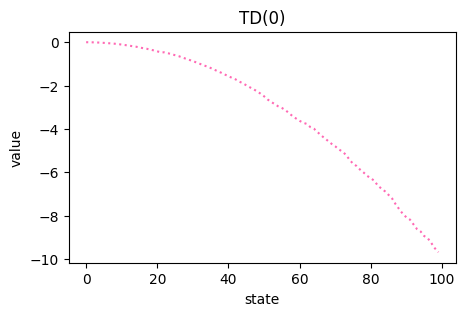

In [88]:
pi_init = policy_aggr()
V_init = value_under_policy(pi_init)

V_td_zero, track_x_t = td_zero(V_init, 99, pi_init, 10e4)
print(f'min state: {min(track_x_t)}')

plot_results(V_td_zero, 'state', 'value', 'TD(0)', 'hotpink')

## <a id='part2'>Part 2: Approximate Policy Iteration</a>
- **Objective**: implement an approximate policy iteration method
- **Tasks:**
  - Create approximate policy iteration method
  - Plot value function after 10 and 100 iterations and compare to value function from Part1
  - Compare the value function to the optimal value function from HW1
  - Plot the service rates assigned by the final policy, interpret